## Face bbox detection:
As the AffectNet dataset is based on face detection, I analyze many face detectors and check two metrics: the average execution time and for the known bodies which of them have a face identified. I will use the following face detectors:

1. [OpenCV (HAAR Cascade) face detector](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html)
2. [YOLOv8 face detector](https://github.com/akanametov/yolov8-face)

*Note: YOLOv8 face detector is forked from the original model and trained by the Github user "akanametov". The model structure is the same as the original one, but the model weights are taken from the mentioned user.*


In [2]:
import cv2
import pandas as pd
import time
from pathlib import Path
import os
import altair as alt
from prettytable import PrettyTable

import torch
print("Cuda is available:", torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("The device is:", torch.cuda.get_device_name(device))

try: 
    from src.visualization.display_annot import plot_bbox_annotations
    from src.models.load_pretrained_models import load_YOLO_model_face_recognition, load_HAAR_cascade_face_detection
    from src.models.inference_face_detection_model import detect_faces_HAAR_cascade, detect_faces_YOLO
    from src import INTERIM_DATA_DIR
except ModuleNotFoundError:
    print("Ensure that src is added to PATH and restart the kernel")

Cuda is available: True
The device is: NVIDIA GeForce GTX 1080 Ti


Load the interim annotations:

In [3]:
annotations_path = Path(os.path.join(INTERIM_DATA_DIR, 'annotations'))
photo_directory = os.path.join(INTERIM_DATA_DIR, "images")

annotations = {}
for data_split in os.listdir(annotations_path):
    if data_split.endswith('.pkl'):
        file = os.path.join(annotations_path, data_split)
        data_part_name = data_split.split('.')[0]
        annotations[data_part_name] = pd.read_pickle(file)

We load the face detectors:

In [4]:
haar_detector = load_HAAR_cascade_face_detection()
yolo_detector = load_YOLO_model_face_recognition(size = "medium", device = device)

In [5]:
def check_face_predictions (body_bbox, faces_bbox, well_detected):
    """ From all given faces, check if they are inside the body bbox. After getting all of them, take the upper face and remove it from the list of faces to check.
    It is assumed that the given format is 'xywh', where xy is the upper left point of the bbox and wh is the width and height of the bbox."""
    
    selected_face = None
    for id, f_bbox in faces_bbox.items():
        upper_left_point_inside = f_bbox[0] >= body_bbox[0] and f_bbox[1] >= body_bbox[1]
        down_right_point_inside = f_bbox[0] + f_bbox[2] <= body_bbox[2] and f_bbox[1] + f_bbox[3] <= body_bbox[3]
        if upper_left_point_inside and down_right_point_inside:
            if selected_face is None:
                selected_face = id
            else:
                if f_bbox[1] < faces_bbox[selected_face][1]: # it is upper in the image
                    selected_face = id
                    
    if selected_face is not None:
        faces_bbox.pop(selected_face)
        well_detected = well_detected+1
        
    return well_detected, faces_bbox

Make an example to show that in fact is detecting faces:

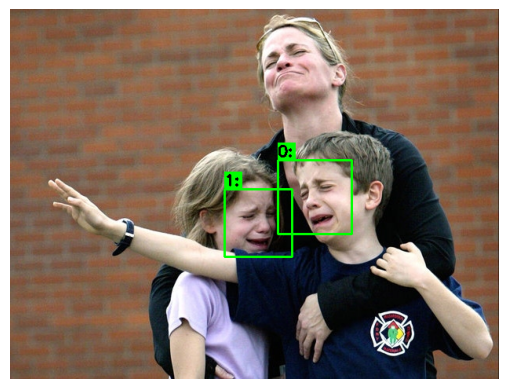

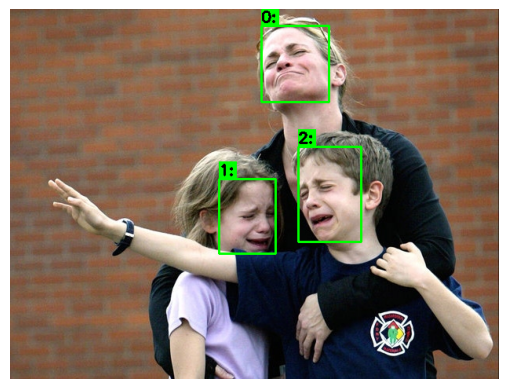

In [6]:
sample = annotations['train'].loc[10]
img_file = sample['path']
img_path = os.path.join(photo_directory, img_file)
img = cv2.imread(img_path)
faces_bbox_HAAR_cascade = detect_faces_HAAR_cascade(img, haar_detector)
[boxes, probs] = detect_faces_YOLO(img, yolo_detector)
plot_bbox_annotations (img, faces_bbox_HAAR_cascade)
plot_bbox_annotations (img, boxes)

In [7]:
execution_time = {'detector_HAAR_cascade': [], 'detect_faces_YOLO': []}
total_people = 0; HAAR_cascade_detections = 0; YOLO_detections = 0
HAAR_cascade_well_detected = 0; YOLO_well_detected = 0

# Preprocess the data
selected_datasplit = 'val'

for photo_idx in range(len(annotations[selected_datasplit])):
    if photo_idx % 100 == 0:
        print("Processing image", photo_idx, "from", len(annotations[selected_datasplit]))
    sample = annotations[selected_datasplit].loc[photo_idx]
    # Read the image
    img_file = sample['path']
    img_path = os.path.join(photo_directory, img_file)
    img = cv2.imread(img_path)

    # HAAR cascade detector
    start = time.time()
    faces_bbox_HAAR_cascade = detect_faces_HAAR_cascade(img, haar_detector)
    end = time.time()
    execution_time['detector_HAAR_cascade'].append(end - start)
    faces_bbox_HAAR_cascade = dict(enumerate(faces_bbox_HAAR_cascade))
    # YOLO detector
    start = time.time()
    [faces_bbox_YOLO, confidence_YOLO] = detect_faces_YOLO(img, yolo_detector)
    end = time.time()
    execution_time['detect_faces_YOLO'].append(end - start)
    faces_bbox_YOLO = dict(enumerate(faces_bbox_YOLO))


    # Get the person data
    total_people += sample['people']
    HAAR_cascade_detections += len(faces_bbox_HAAR_cascade)
    YOLO_detections += len(faces_bbox_YOLO)
    for person_idx in range(sample['people']):
        body_bbox = sample['bbox'][person_idx]
        HAAR_cascade_well_detected, faces_bbox_HAAR_cascade = check_face_predictions(body_bbox, faces_bbox_HAAR_cascade, HAAR_cascade_well_detected)
        YOLO_well_detected, faces_bbox_YOLO = check_face_predictions(body_bbox, faces_bbox_YOLO, YOLO_well_detected)

Processing image 0 from 2088
Processing image 100 from 2088
Processing image 200 from 2088
Processing image 300 from 2088
Processing image 400 from 2088


In [ ]:
tp_H = HAAR_cascade_well_detected
fp_H = HAAR_cascade_detections - HAAR_cascade_well_detected
tn_H = 0
fn_H = total_people - HAAR_cascade_well_detected

# Assuming you have the following confusion matrix
data_HAAR = {'Actual': ['Positive', 'Negative'],
        'Positive': [tp_H, fp_H],  # Predicted Positive
        'Negative': [fn_H, tn_H]}  # Predicted Negative

df_HAAR = pd.DataFrame(data_HAAR).melt('Actual', var_name='Predicted', value_name='Count')

# Create the confusion matrix
bar = alt.Chart(df_HAAR).mark_rect().encode(
    x=alt.X('Actual:O', sort = ['Positive', 'Negative'], axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Predicted:O', sort = ['Positive', 'Negative']),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
    text= 'Count:Q'
).properties(width=200, height=200)
text = alt.Chart(df_HAAR).mark_text().encode(
    x=alt.X('Actual:O', sort = ['Positive', 'Negative'], axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Predicted:O', sort = ['Positive', 'Negative']),
    text='Count:Q'
)

confusion_matrix_HAAR_cascade = bar + text

confusion_matrix_HAAR_cascade = confusion_matrix_HAAR_cascade.properties(
title='Confusion matrix for HAAR cascade detector')

Same for YOLOv8:

In [ ]:
tp_Y = YOLO_well_detected
fp_Y = YOLO_detections - YOLO_well_detected
tn_Y = 0
fn_Y = total_people - YOLO_well_detected

# Assuming you have the following confusion matrix
data_YOLO = {'Actual': ['Positive', 'Negative'],
        'Positive': [tp_Y, fp_Y],  # Predicted Positive
        'Negative': [fn_Y, tn_Y]}  # Predicted Negative

df_YOLO = pd.DataFrame(data_YOLO).melt('Actual', var_name='Predicted', value_name='Count')

# Create the confusion matrix
bar = alt.Chart(df_YOLO).mark_rect().encode(
    x=alt.X('Actual:O', sort = ['Positive', 'Negative'], axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Predicted:O', sort = ['Positive', 'Negative']),
    color=alt.Color('Count:Q', scale=alt.Scale(scheme='blues')),
    text= 'Count:Q'
).properties(width=200, height=200)
text = alt.Chart(df_YOLO).mark_text().encode(
    x=alt.X('Actual:O', sort = ['Positive', 'Negative'], axis=alt.Axis(labelAngle=0)),
    y=alt.Y('Predicted:O', sort = ['Positive', 'Negative']),
    text='Count:Q'
)

confusion_matrix_YOLO = bar + text

confusion_matrix_YOLO = confusion_matrix_YOLO.properties(
title='Confusion matrix for YOLO detector')

Now we can visualize the results:

In [ ]:
confusion_matrices = alt.hconcat(confusion_matrix_HAAR_cascade, confusion_matrix_YOLO)

confusion_matrices.display()

alt.HConcatChart(...)

Compute the precision, recall and F1-score for the face detection:

In [ ]:
# Calculate precision, recall, and F1 score for HAAR
precision_HAAR = tp_H / (tp_H + fp_H)
recall_HAAR = tp_H / (tp_H + fn_H)
f1_HAAR = 2 * (precision_HAAR * recall_HAAR) / (precision_HAAR + recall_HAAR)

# Calculate precision, recall, and F1 score for YOLO
precision_YOLO = tp_Y / (tp_Y + fp_Y)
recall_YOLO = tp_Y / (tp_Y + fn_Y)
f1_YOLO = 2 * (precision_YOLO * recall_YOLO) / (precision_YOLO + recall_YOLO)

In [ ]:
# Create a PrettyTable object
table = PrettyTable()

# Add columns
table.field_names = ["Method", "Precision", "Recall", "F1 Score"]
table.add_row(["HAAR", "{:.2f}%".format(precision_HAAR*100), "{:.2f}%".format(recall_HAAR*100), "{:.2f}%".format(f1_HAAR*100)])
table.add_row(["YOLO", "{:.2f}%".format(precision_YOLO*100), "{:.2f}%".format(recall_YOLO*100), "{:.2f}%".format(f1_YOLO*100)])

# Print the table
print(table)

+--------+-----------+--------+----------+
| Method | Precision | Recall | F1 Score |
+--------+-----------+--------+----------+
|  HAAR  |   39.92%  | 30.22% |  34.40%  |
|  YOLO  |   31.21%  | 86.92% |  45.93%  |
+--------+-----------+--------+----------+


The results for precision are not very promising, but we have to keep in mind that there are many people that present in photos that have no emotion annotated. So, we have to check the recall to see if the face detection is good enough. The recall is 0.95, which is very good, and the F1-score is 0.93, which is also very good. So, we can say that the face detection is good enough for our purposes.